In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import jax
import jax.numpy as np

from jax import lax, random
from jax.api import grad, jit, vmap
from jax.config import config
from jax.experimental import optimizers
from jax.experimental.stax import logsoftmax

import neural_tangents as nt
import neural_tangents.stax as stax

from functools import partial
from cleverhans.utils import clip_eta, one_hot
from utils import *

## minist down sample

In [2]:
# x_train, y_train, x_test, y_test = tuple(np.array(x) for x in get_dataset('mnist', 256, 10000))
x_train, y_train, x_test, y_test = tuple(np.array(x) for x in get_dataset('mnist', 256, 512, 
                                                                          do_flatten_and_normalize=False))

In [3]:
diag_reg_default = 1e-4 # for inverse solve
config.update('jax_enable_x64', True) # for inverse precision

In [4]:
def accuracy(mean, ys):
    return np.mean(np.argmax(mean, axis=-1) == np.argmax(ys, axis=-1))

In [5]:
def WideDenseBlock(output_dim, W_std=1.0, b_std=0.0):
    return stax.serial(stax.Dense(output_dim, W_std=W_std, b_std=b_std),
                       stax.Erf())

def WideDenseGroup(layer_num, output_dim, W_std, b_std):
    blocks = []
    blocks += [WideDenseBlock(output_dim, W_std, b_std)]
    for _ in range(layer_num - 1):
        blocks += [WideDenseBlock(output_dim, W_std, b_std)]
        
    return stax.serial(*blocks)

In [6]:
l2_loss = lambda x1, x2, weight: ((x1 - x2)**2*weight)*0.5 # tf version
cross_entropy = lambda fx, y_hat: -np.mean(stax.logsoftmax(fx) * y_hat)

In [7]:
# x1 = random.normal(k[1], (10 ,1))
# x2 = random.normal(k[2], (10 ,1))

In [8]:
# unused
def train_loss_adv(x_train, y, kernel_fn, weight):
    # Compute NTK on training data
    ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    loss = - l2_loss(ntk_train_train, y, weight) # y = matrix of 1 / diagnal
    return loss

# train_grads_fn = grad(train_loss_adv)
train_grads_fn = jit(grad(train_loss_adv), static_argnums=(2,)) # static arg: expanding {if / else} loops for graph mode

In [9]:
x_train.shape

(256, 784)

In [10]:
x_test[None].shape

(1, 512, 784)

In [11]:
# unused
def test_loss_adv_mse(x_train, x_test, y_train, y, kernel_fn, diag_reg=diag_reg_default):
    # Kernel
    ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    ntk_test_train = kernel_fn(x_test[None], x_train, 'ntk')
    # ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
    
    # Prediction
    predict_fn = nt.predict.gradient_descent_mse(ntk_train_train, y_train, diag_reg=diag_reg_default) # diag_reg: add to easier inverse
    pred = predict_fn(None, 0., 0., ntk_test_train)[1]
    
    loss = - np.sum(logsoftmax(pred) * y)
    # if targeted:
    #     loss = -loss
    return loss

test_mse_grads_fn = jit(vmap(grad(test_loss_adv_mse, argnums=1), in_axes=(None, 0, None, 0, None), out_axes=0), static_argnums=(4,))

In [12]:
# unused
def test_loss_adv_cross_entropy(x_train, x_test, y_train, y, kernel_fn, diag_reg=diag_reg_default):
    # Kernel
    ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    ntk_test_train = kernel_fn(x_test[None], x_train, 'ntk')
    # ntk_test_train = kernel_fn(x_test, x_train, 'ntk')

    
    # Prediction
    predict_fn = nt.predict.gradient_descent(cross_entropy, ntk_train_train, y_train, diag_reg=diag_reg_default) # diag_reg: add to easier inverse
    pred = predict_fn(None, 0., 0., ntk_test_train)[1]
    
    loss = - np.sum(logsoftmax(pred) * y)
    # if targeted:
    #     loss = -loss
    return loss

test_cross_entropy_grads_fn = jit(vmap(grad(test_loss_adv_cross_entropy, argnums=1), in_axes=(None, 0, None, 0, None), out_axes=0), static_argnums=(4,))

In [13]:
def model_mse_fn(kernel_fn, obj_fn, x_train=None, x_test=None, fx_train_0=0., fx_test_0=0., diag_reg=diag_reg_default):
    # Kernel
    ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    
    if obj_fn == 'train':
        return ntk_train_train
    elif obj_fn == 'test':
        ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
        # Prediction
        predict_fn = nt.predict.gradient_descent_mse(ntk_train_train, y_train, diag_reg=diag_reg) # no convariance
        return predict_fn(None, fx_train_0, fx_test_0, ntk_test_train) # fx_train_0, diag_reg_default = (0, 0) for infinite width
    else:
        raise ValueError("Objective function must be either train(ntk_train_train) or test(predict_fn)")

In [14]:
def model_cross_entropy_fn(kernel_fn, obj_fn, x_train=None, x_test=None, fx_train_0=0., fx_test_0=0., diag_reg=diag_reg_default):
    # Kernel
    ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    
    if obj_fn == 'train':
        return ntk_train_train
    elif obj_fn == 'test':
        ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
        # Prediction
        predict_fn = nt.predict.gradient_descent(cross_entropy, ntk_train_train, y_train, diag_reg=diag_reg_default) # no convariance
        return predict_fn(None, fx_train_0, fx_test_0, ntk_test_train) # fx_train_0, fx_test_0 = (0, 0) for infinite width
    else:
        raise ValueError("Objective function must be either train(ntk_train_train) or test(predict_fn)")

In [15]:
def fast_gradient_method(model_fn, kernel_fn, obj_fn, grads_fn, loss_weighting, phase, x_train, x_test, 
                         fx_train_0=0.0, fx_test_0=0.0, eps=0.3, norm=np.inf, clip_min=None, clip_max=None, 
                         y_train=None, y=None, targeted=False):
    """
    JAX implementation of the Fast Gradient Method.
    :param model_fn: a callable that takes an input tensor and returns the model logits.
    :param x: input tensor.
    :param eps: epsilon (input variation parameter); see https://arxiv.org/abs/1412.6572.
    :param norm: Order of the norm (mimics NumPy). Possible values: np.inf or 2.
    :param clip_min: (optional) float. Minimum float value for adversarial example components.
    :param clip_max: (optional) float. Maximum float value for adversarial example components.
    :param y: (optional) Tensor with one-hot true labels. If targeted is true, then provide the
            target one-hot label. Otherwise, only provide this parameter if you'd like to use true
            labels when crafting adversarial samples. Otherwise, model predictions are used
            as labels to avoid the "label leaking" effect (explained in this paper:
            https://arxiv.org/abs/1611.01236). Default is None. This argument does not have
            to be a binary one-hot label (e.g., [0, 1, 0, 0]), it can be floating points values
            that sum up to 1 (e.g., [0.05, 0.85, 0.05, 0.05]).
    :param targeted: (optional) bool. Is the attack targeted or untargeted?
            Untargeted, the default, will try to make the label incorrect.
            Targeted will instead try to move in the direction of being more like y.
            
    :return: a tensor for the adversarial example
    """
    if norm not in [np.inf, 2]:
        raise ValueError("Norm order must be either np.inf or 2.")
        
    # define y if y is none
    if obj_fn == 'train':
        x = x_train
        if y is None:
            # Compute NTK on training data
            ntk_train_train = model_fn(kernel_fn=kernel_fn, obj_fn='train', x_train=x_train)
            
            # Construct diagonal
            if phase == 'ordered':
                y = np.ones(ntk_train_train.shape)*100
            elif phase == 'chaotic':
                y = np.eye(ntk_train_train.shape[0])*100
            else:
                raise ValueError("Phase must be either 'ordered' or 'critical'")
                
    elif obj_fn == 'test':
        x = x_test
        # target
        if y is None:
            # Using model predictions as ground truth to avoid label leaking
            # x_labels = np.argmax(model_fn(kernel_fn, 'test', x_train, x_test, fx_train_0, fx_test_0)[1], 1)
            # y = one_hot(x_labels, 10)
            # Construct diagonal
            if phase == 'ordered':
                y = np.ones(ntk_train_train.shape)*100
            elif phase == 'chaotic':
                y = np.eye(ntk_train_train.shape[0])*100
            else:
                raise ValueError("Phase must be either 'ordered' or 'critical'")
            
        if y_train is None:
            x_labels = np.argmax(model_fn(kernel_fn, 'test', x_train, x_train, fx_train_0, fx_test_0)[1], 1)
            y_train = one_hot(x_labels, 10)
    
    if obj_fn == 'train':
        grads = grads_fn(x_train, y, kernel_fn, loss_weighting)
    elif obj_fn == 'test':
        grads = grads_fn(x_train, x_test, y_train, y, kernel_fn)
    else:
        raise ValueError("Objective function must be either train(ntk_train_train) or test(predict_fn)")

    axis = list(range(1, len(grads.shape)))
    avoid_zero_div = 1e-12
    if norm == np.inf:
        perturbation = eps * np.sign(grads)
    elif norm == 1:
        raise NotImplementedError("L_1 norm has not been implemented yet.")
    elif norm == 2:
        square = np.maximum(avoid_zero_div, np.sum(np.square(grads), axis=axis, keepdims=True))
        perturbation = grads / np.sqrt(square)

    adv_x = x + perturbation

    # If clipping is needed, reset all values outside of [clip_min, clip_max]
    if (clip_min is not None) or (clip_max is not None):
        # We don't currently support one-sided clipping
        assert clip_min is not None and clip_max is not None
        adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)
        
    return adv_x

In [16]:
def projected_gradient_descent(model_fn, kernel_fn, obj_fn, grads_fn, loss_weighting, phase, x_train, x_test,
                               fx_train_0=0., fx_test_0=0., eps=0.3, eps_iter=0.03, nb_iter=10, norm=np.inf, 
                               clip_min=None, clip_max=None, y_train=None, y=None, targeted=False, 
                               rand_init=None, rand_minmax=0.3):
    """
    This class implements either the Basic Iterative Method
    (Kurakin et al. 2016) when rand_init is set to 0. or the
    Madry et al. (2017) method when rand_minmax is larger than 0.
    Paper link (Kurakin et al. 2016): https://arxiv.org/pdf/1607.02533.pdf
    Paper link (Madry et al. 2017): https://arxiv.org/pdf/1706.06083.pdf
    :param model_fn: a callable that takes an input tensor and returns the model logits.
    :param x: input tensor.
    :param eps: epsilon (input variation parameter); see https://arxiv.org/abs/1412.6572.
    :param eps_iter: step size for each attack iteration
    :param nb_iter: Number of attack iterations.
    :param norm: Order of the norm (mimics NumPy). Possible values: np.inf or 2.
    :param clip_min: (optional) float. Minimum float value for adversarial example components.
    :param clip_max: (optional) float. Maximum float value for adversarial example components.
    :param y: (optional) Tensor with true labels. If targeted is true, then provide the
            target label. Otherwise, only provide this parameter if you'd like to use true
            labels when crafting adversarial samples. Otherwise, model predictions are used
            as labels to avoid the "label leaking" effect (explained in this paper:
            https://arxiv.org/abs/1611.01236). Default is None.
    :param targeted: (optional) bool. Is the attack targeted or untargeted?
            Untargeted, the default, will try to make the label incorrect.
            Targeted will instead try to move in the direction of being more like y.
    :return: a tensor for the adversarial example
    """

    assert eps_iter <= eps, (eps_iter, eps)
    if norm == 1:
        raise NotImplementedError("It's not clear that FGM is a good inner loop"
                                  " step for PGD when norm=1, because norm=1 FGM "
                                  " changes only one pixel at a time. We need "
                                  " to rigorously test a strong norm=1 PGD "
                                  "before enabling this feature.")
    if norm not in [np.inf, 2]:
        raise ValueError("Norm order must be either np.inf or 2.")
        
    
    if obj_fn == 'train':
        x = x_train
        if y is None:
            # Compute NTK on training data
            ntk_train_train = model_fn(kernel_fn=kernel_fn, obj_fn='train', x_train=x_train)
            
            # Construct diagonal
            if phase == 'ordered':
                y = np.ones(ntk_train_train.shape)*100
            elif phase == 'chaotic':
                y = np.eye(ntk_train_train.shape[0])*100
            else:
                raise ValueError("Phase must be either 'ordered' or 'critical'")
                
    elif obj_fn == 'test':
        x = x_test
        if y is None:
            # Using model predictions as ground truth to avoid label leaking
            x_labels = np.argmax(model_fn(kernel_fn, 'test', x_train, x_test, fx_train_0, fx_test_0)[1], 1)
            y = one_hot(x_labels, 10)
            
        if y_train is None:
            x_labels = np.argmax(model_fn(kernel_fn, 'test', x_train, x_train, fx_train_0, fx_test_0)[1], 1)
            y_train = one_hot(x_labels, 10)
            
    else:
        raise ValueError("Objective function must be either train(ntk_train_train) or test(predict_fn)")
        
    # Initialize loop variables
    if rand_init:
        rand_minmax = eps
        eta = random.uniform(new_key, x.shape, minval=-rand_minmax, maxval=rand_minmax)
    else:
        eta = np.zeros_like(x)

    # Clip eta
    eta = clip_eta(eta, norm, eps)
    adv_x = x + eta
    if clip_min is not None or clip_max is not None:
        adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)
        
    for _ in range(nb_iter):
        if obj_fn == 'test':
            adv_x = fast_gradient_method(model_fn, kernel_fn, obj_fn, grads_fn, loss_weighting, phase, x_train, adv_x, 
                                         fx_train_0=0., fx_test_0=0., eps=eps_iter, norm=np.inf, clip_min=clip_min, 
                                         clip_max=clip_max, y_train=y_train, y=y, targeted=targeted)
        elif obj_fn == 'train':
            adv_x = fast_gradient_method(model_fn, kernel_fn, obj_fn, grads_fn, loss_weighting, phase, adv_x, x_test, 
                                         fx_train_0=0., fx_test_0=0., eps=eps_iter, norm=np.inf, clip_min=clip_min, 
                                         clip_max=clip_max, y_train=y_train, y=y, targeted=targeted)

        # Clipping perturbation eta to norm norm ball
        eta = adv_x - x
        eta = clip_eta(eta, norm, eps)
        adv_x = x + eta

        # Redo the clipping.
        # FGM already did it, but subtracting and re-adding eta can add some
        # small numerical error.
        if clip_min is not None or clip_max is not None:
            adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)

    return adv_x

## the three phases

In [17]:
variance_b = 0.18
variance_w = np.asarray([1., 1.76, 2.5])
phase_list = ['Ordered', 'Critical', 'Chaotic']

layer_num = 50
num_classes = 10

kernel_list = []
fx_train_0_list = []
fx_test_0_list = []

key = random.PRNGKey(0)

b_std = np.sqrt(variance_b)

for w_std in np.sqrt(variance_w):
    init_fn, apply_fn, kernel_fn = stax.serial(WideDenseGroup(layer_num=layer_num, output_dim=1024, 
                                                              W_std=w_std, b_std=b_std), 
                                               stax.Dense(num_classes, W_std=w_std, b_std=b_std))
    
    # Inference with a single infinite width / linearized network
    apply_fn = jit(apply_fn)
    kernel_fn = jit(kernel_fn, static_argnums=(2,))
    kernel_list.append(kernel_fn)
    
#     _, params = init_fn(key, (-1, x_train.shape[1]))
#     fx_train_0_list.append(apply_fn(params, x_train))
#     fx_test_0_list.append(apply_fn(params, x_test))

## model training

In [18]:
for phase, kernel in zip(phase_list, kernel_list):
    _, fx_test = model_mse_fn(kernel, 'test', x_train, x_test)
    acc = accuracy(fx_test, y_test)
    print("Clean Acc({:s}): {:.2f}".format(phase, acc))

Clean Acc(Ordered): 0.22
Clean Acc(Critical): 0.85
Clean Acc(Chaotic): 0.08


## attck gerneration

In [19]:
phase = 'chaotic'
n = x_train.shape[0]
w = n**2 - n
w = 1e4
d = 1
eye = np.eye(n)
loss_weighting = np.where(eye==0, 1/w, eye) * d

In [20]:
attack_type = ["Clean", "FGSM", "PGD-10", "PGD-100"]
x_test_list = []

In [21]:
x_test_list.append(x_test)

# FGSM
x_test_list.append(fast_gradient_method(model_fn=model_mse_fn, kernel_fn=kernel_list[1], obj_fn='test', 
                                         grads_fn=test_mse_grads_fn, loss_weighting=loss_weighting, phase=phase, 
                                         x_train=x_train, x_test=x_test, eps=0.3, clip_min=0, clip_max=1, y=None, 
                                         targeted=False))

# PGD 10
key, new_key = random.split(key)
x_test_list.append(projected_gradient_descent(model_fn=model_mse_fn, kernel_fn=kernel_list[1], obj_fn='test', 
                                               grads_fn=test_mse_grads_fn, loss_weighting=loss_weighting, phase=phase,
                                               x_train=x_train, x_test=x_test, eps=0.3, eps_iter=0.04, nb_iter=10, 
                                               clip_min=0, clip_max=1, y=None, targeted=False, rand_init=True, 
                                               rand_minmax=0.3))

# PGD 100
key, new_key = random.split(key)
x_test_list.append(projected_gradient_descent(model_fn=model_mse_fn, kernel_fn=kernel_list[1], obj_fn='test', 
                                               grads_fn=test_mse_grads_fn, loss_weighting=loss_weighting, phase=phase,
                                               x_train=x_train, x_test=x_test, eps=0.3, eps_iter=0.004, nb_iter=100, 
                                               clip_min=0, clip_max=1, y=None, targeted=False, rand_init=True, 
                                               rand_minmax=0.3))

# Evaluation
print("diag/off-diag: {:.5f}/{:.5f}".format(loss_weighting[0][0], loss_weighting[0][1]))

for idx, _x_test in enumerate(x_test_list):
    _, fx_adv_test_t = model_mse_fn(kernel_list[1], 'test', x_train, _x_test)
    acc = accuracy(fx_adv_test_t, y_test)
    print("Robustness({:s}): {:.2f}".format(attack_type[idx], acc))

UnboundLocalError: local variable 'ntk_train_train' referenced before assignment

In [22]:
len(x_test_list)

1

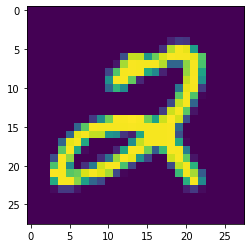

In [23]:
plt.imshow(x_test_list[0][0].reshape((28,28)))

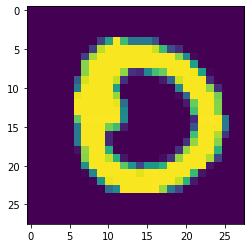

In [24]:
plt.imshow(x_test[1].reshape((28,28)))

## questions

why y_train = None ?